In [1]:
import streamlit as st
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import nltk
import math
import torch

In [2]:
model_name = "afnanmmir/t5-base-abstract-to-plain-language-1"
# model_name = "afnanmmir/t5-base-axriv-to-abstract-3"
max_input_length = 1024
max_output_length = 256
min_output_length = 64

In [6]:
def load_model():
    print("Loading model...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    nltk.download('punkt')
    print("Model loaded!")
    return tokenizer, model

tokenizer, model = load_model()

Loading model...
Model loaded!


[nltk_data] Downloading package punkt to /home/pintos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
def generate_summary(text):
    inputs = ["summarize: " + text]
    inputs = tokenizer(inputs, return_tensors="pt", max_length=max_input_length, truncation=True)

    outputs = model.generate(**inputs, do_sample=True, max_length=max_output_length, num_beams=8, min_length=min_output_length)
    decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    predicted_summaries = nltk.sent_tokenize(decoded_outputs.strip())
    
    return predicted_summaries

In [8]:

import json

from datasets import load_dataset
dataset = load_dataset('json', data_files='./plos_readability_ctrl_sum_corpus/test_plos.jsonl')
output_file = open("./plos_readability_ctrl_sum_corpus_output/test_plos_output.jsonl", "w")

for i in range(1000):
    title = dataset["train"][i]["title"]
    abstract = dataset["train"][i]["abstract"]
    plain_language_summary = dataset["train"][i]["plain language summary"]
    article = dataset["train"][i]["article"]

    predicted_summary = generate_summary(abstract)
    predicted_summary = " ".join(predicted_summary)

    # json.dump({"title": title, "predicted summary": predicted_summary}, output_file)

    output_file.write(json.dumps({"title": title, "predicted summary": predicted_summary}) + '\n')

    if (i % 50 == 0):
        print("Processed " + str(i) + " articles")

output_file.close()



2023-04-15 20:08:10.200 WARNING datasets.builder: Found cached dataset json (/home/pintos/.cache/huggingface/datasets/json/default-3bfbc9858e2f56f0/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)


  0%|          | 0/1 [00:00<?, ?it/s]

Processed 0 articles
Processed 50 articles
Processed 100 articles
Processed 150 articles
Processed 200 articles
Processed 250 articles
Processed 300 articles
Processed 350 articles
Processed 400 articles
Processed 450 articles
Processed 500 articles
Processed 550 articles
Processed 600 articles
Processed 650 articles
Processed 700 articles
Processed 750 articles
Processed 800 articles
Processed 850 articles
Processed 900 articles
Processed 950 articles


In [46]:
# predicted_summary = generate_summary(abstract)
# predicted_summary = " ".join(predicted_summary)

In [2]:
from datasets import load_dataset
import textstat

test_dataset = load_dataset('json', data_files='./plos_readability_ctrl_sum_corpus/test_plos.jsonl')
predicted_dataset = load_dataset('json', data_files='./plos_readability_ctrl_sum_corpus_output/test_plos_output.jsonl')

abstract_score = list()
plain_language_summary_score = list()
predicted_summary_score = list()

for i in range(1000):
    abstract = test_dataset["train"][i]["abstract"]
    plain_language_summary = test_dataset["train"][i]["plain language summary"]
    predicted_summary = predicted_dataset["train"][i]["predicted summary"]

    abstract_score.append(textstat.flesch_reading_ease(abstract))
    plain_language_summary_score.append(textstat.flesch_reading_ease(plain_language_summary))
    predicted_summary_score.append(textstat.flesch_reading_ease(predicted_summary))


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /home/pintos/.cache/huggingface/datasets/json/default-7c4ac344410fb82a/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset json (/home/pintos/.cache/huggingface/datasets/json/default-2fe7adf397160333/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)


  0%|          | 0/1 [00:00<?, ?it/s]

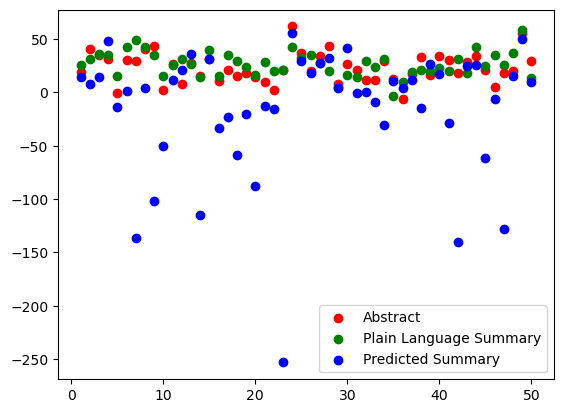

In [6]:
# plot the scores as a line
import matplotlib.pyplot as plt

x_val = list()
for i in range(1000):
    x_val.append(i+1)

plt.scatter(x_val[:50], abstract_score[:50], color="red")
plt.scatter(x_val[:50], plain_language_summary_score[:50], color="green")
plt.scatter(x_val[:50], predicted_summary_score[:50], color="blue")
plt.legend(["Abstract", "Plain Language Summary", "Predicted Summary"])
plt.show()